# LASIF with Salvus

LASIF can in theory be used in combination with any wave propagation solver which solves both the forward and the adjoint wave equation. The solver which integrates most easily with [LASIF](https://dirkphilip.github.io/LASIF_2.0/) is [Salvus](https://mondaic.com) as this version of LASIF was originally developed for Salvus and currently contains some nice utilities which ease the combination of the two.

In this tutorial we will show how we can combine the two and create a nice workflow. This tutorial does not contain any sort of optimization routines to progress through iterations but only the general things of how to perform forward and adjoint simulations and the steps that are needed in between. _LASIF_ works both through command line and an API. In this tutorial we will use the API as we believe it to be a nicer interface and it can be used for scripting.

The _Salvus_ support of _LASIF_ is currently based on _Salvus_ version 0.11.0 or higher. If you have an older version, the only thing you have to do is to go into the `salvus_utils.py` file inside _LASIF_ and change all the calls to _Salvus_ python packages from `salvus.something` to `salvus_something`.

__Author of tutorial:__
_Solvi Thrastarson_
soelvi.thrastarson@erdw.ethz.ch


In [1]:
# Input of various libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import toml
import pathlib
import pprint
from typing import Union, Dict, List

import obspy
import lasif.api
from lasif import salvus_utils

from salvus.mesh.simple_mesh import basic_mesh

## Define a project

Here we define our project and make the initial setup required to make a project run.

In [2]:
# Project Definition
project_name = "lasif_project"
lasif_root = pathlib.Path(os.getcwd()) / project_name

lasif.api.init_project(project_path=lasif_root)

LASIFError: The given PROJECT_PATH already exists. It must not exist yet.

The directory structure which Lasif has created can be visualized using the __tree__ command. (You may have to install the software to do so)

In [3]:
!tree

.
|-- Lasif_with_salvus.ipynb
|-- README.md
`-- lasif_project
    |-- ADJOINT_SOURCES
    |-- DATA
    |   |-- CORRELATIONS
    |   `-- EARTHQUAKES
    |-- FUNCTIONS
    |   |-- __init__.py
    |   |-- preprocessing_function_asdf.py
    |   |-- process_data.py
    |   |-- process_synthetics.py
    |   |-- source_time_function.py
    |   `-- window_picking_function.py
    |-- GRADIENTS
    |-- ITERATIONS
    |-- MODELS
    |-- OUTPUT
    |   `-- LOGS
    |-- PROCESSED_DATA
    |   |-- CORRELATIONS
    |   `-- EARTHQUAKES
    |-- SETS
    |   |-- WEIGHTS
    |   `-- WINDOWS
    |       `-- A.sqlite
    |-- SYNTHETICS
    |   |-- CORRELATIONS
    |   `-- EARTHQUAKES
    `-- lasif_config.toml

20 directories, 10 files


The directory structure is design to incorporate all the files you might accumulate during an inversion in an easily understandable way. There is a weak support for using correlations but I take no responsibility for that working in any sense.
One key file that we can see is the __lasif_config.toml__. This is where you define all the relevant parameters for your inversion. This is a toml file which can be loaded in an operated on as a dictionary in Python. Let's take a look at what's inside.

In [3]:
# Read config file
config_file_path = lasif_root / "lasif_config.toml"
config_dict = toml.load(config_file_path)
pp = pprint.PrettyPrinter()
pp.pprint(config_dict)

{'lasif_project': {'description': '',
                   'domain_settings': {'boundary_in_km': 100.0,
                                       'comment': 'Here you specify your '
                                                  'domain with an hdf5 mesh '
                                                  'and how thick of a boundary '
                                                  'you need regarding data '
                                                  'downloading (i.e. What is '
                                                  'the minimum distance from '
                                                  'the boundary which data can '
                                                  'be downloded)',
                                       'domain_file': '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/MODELS/mesh.h5'},
                   'download_settings': {'channel_priorities': ['BH?',
                                                                'LH[Z,N,E]

As you can see there are many things to configure there. Usually they are explained through comments but if anything is unclear, feel free to ask. Through the __toml__ library it is possible to edit this config at will as long as the correct keys are used in the dictionary and the correct types are inserted as values.

## Define the domain

Since this is a Lasif with Salvus tutorial we can use Salvus to create a mesh which defines our domain. We will thus use one of the easy to use built in Salvus meshes, curtesy of Martin van Driel.

In [4]:
# Create mesh
def create_spherical_chunk(file_location: Union[pathlib.Path, str], mesh_info: dict):
    """
    Create a mesh and write it to file.
    
    :params file_location: Path to the where the mesh should be stored.
    :type file_location: Union[pathlib.Path, str]
    :params mesh_info: basic_info needed for the mesh construction
    :type mesh_info: Dict[str, float]
    """
    
    m = basic_mesh.SphericalChunkBuiltIn3D(
        model=mesh_info["model"],
        period=mesh_info["period"],
        latitude_extent=mesh_info["latitude_extent"],
        longitude_extent=mesh_info["longitude_extent"],
        tensor_order=mesh_info["tensor_order"],
        latitude_center=mesh_info["latitude_center"],
        longitude_center=mesh_info["longitude_center"],
        elements_per_wavelength=mesh_info["elements_per_wavelength"],
        minimum_radius_in_km=mesh_info["minimum_radius_in_km"]
    )
    mesh = m.create_mesh()
    mesh.write_h5(file_location)
    
    return mesh

# We can write the mesh into the location where the lasif_config.toml already thinks it is
file_location = config_dict["lasif_project"]["domain_settings"]["domain_file"]
mesh_info = {
    "model": "prem_iso_one_crust",
    "period": 30.0,
    "latitude_extent": 9.0,
    "longitude_extent": 11.0,
    "tensor_order": 4,
    "latitude_center": 41.0,
    "longitude_center": 12.5,
    "elements_per_wavelength": 1.5,
    "minimum_radius_in_km": 5200.0,
}

mesh = create_spherical_chunk(file_location=file_location, mesh_info=mesh_info)
mesh

So now lasif should know it's domain and we defined in the __lasif_config.toml__ a specific boundary length which we also have to consider. This boundary length (lasif_project.domain_settings.boundary_in_km) is only used when deciding whether datapoints are inside the domain or not. We will leave this parameter at a 100 km and continue. 

This parameter is not to be confused with the absorbing boundaries. There is another parameter for actual absorbing boundaries in the salvus_settings of the config.

## Finding Sources

Lasif has two ways of finding sources. One via the [GCMT catalog](https://www.globalcmt.org/CMTsearch.html) and another one via [IRIS spud events](http://ds.iris.edu/spud/momenttensor). The GCMT way is nice when you just want to get some events with a certain criteria which fit into your domain. The spud events work better if there are specific events that you want to use.

In this tutorial we'll use the GCMT catalog. When looking for events it filters the catalog to only have the events which fit the specified criteria and uses the [Mitchell's best candidate](https://bl.ocks.org/mbostock/d7bf3bd67d00ed79695b) algorithm to select events with a somewhat optimal distribution.

In [6]:
# Find earthquakes
lasif.api.add_gcmt_events(
    lasif_root=lasif_root,
    count=2,
    min_mag=4.5,
    max_mag=5.5,
    min_dist=100.0,
    min_year=2012
)

LASIF currently contains GCMT data from 2005 to 2018/4.
Parsing the GCMT catalog. This might take a while...
	Reading year 2012 ...
	Reading year 2013 ...
	Reading year 2014 ...
	Reading year 2015 ...
	Reading year 2016 ...
	Reading year 2017 ...
	Reading year 2018 ...
Filtering to only include events inside domain...
(2, 140)
34 valid events remain. Starting selection process...
	Selected event with the next closest event being 1500.8 km away.
Selected 2 events.
Written lasif_project/DATA/EARTHQUAKES/GCMT_event_GREECE_Mag_5.1_2014-11-8-23.h5
Written lasif_project/DATA/EARTHQUAKES/GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23.h5


As requested, Lasif found 2 earthquakes for us. We can now plot these events to see their distribution.

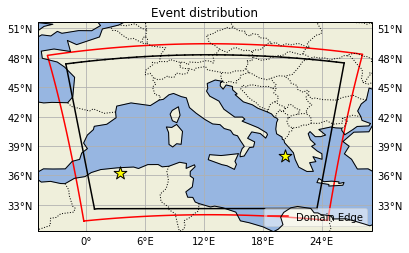

In [5]:
# Plot events
lasif.api.plot_events(
    lasif_root=lasif_root
)

## Download Data

LASIF uses the [Obspy](https://github.com/obspy/obspy/wiki) MassDownloader to download the available data for the sources in the project. It is possible to configure this downloader to do many different things. Some things you can modify in the LASIF config file but in many cases I would recommend just looking into the downloader in lasif and modifying it at will in there if you have any special requests.

Let's first modify the config file to have smarter download settings.

In [8]:
# Change download length
download_after = 1200.0
config_dict["lasif_project"]["download_settings"]["seconds_after_event"] = download_after
with open(config_file_path, "w") as fh:
    toml.dump(config_dict, fh)

In [9]:
# Download data
lasif.api.download_data(
    lasif_root=lasif_root,
)

[2020-03-18 17:42:59,343] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for BGR, EMSC, ETH, GEONET, GFZ, ICGC, INGV, IPGP, ISC, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, TEXNET, USGS, USP, ORFEUS, IRIS.
[2020-03-18 17:42:59,832] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'USGS' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:42:59,992] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'ISC' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:43:03,760] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'EMSC' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:43:03,762] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 18 client(s): BGR, ETH, GEONET, GFZ, ICGC, INGV, IPGP, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, TEXNET, USP, ORFEUS, IRIS.
[2020-03-18 17:43:03,763] - obspy.clients.fdsn.mass_downloader - INFO: Total ac

(2, 140)


[2020-03-18 17:43:04,576] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Successfully requested availability (0.76 seconds)
[2020-03-18 17:43:04,595] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Found 3 stations (9 channels).
[2020-03-18 17:43:04,598] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Will attempt to download data from 3 stations.
[2020-03-18 17:43:04,600] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Status for 9 time intervals/channels before downloading: NEEDS_DOWNLOADING
[2020-03-18 17:43:09,350] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Successfully downloaded 9 channels (of 9)
[2020-03-18 17:43:09,351] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Launching basic QC checks...
[2020-03-18 17:43:09,372] - obspy.clients.fdsn.mass_downloader - INFO: Client 'BGR' - Downloaded 0.3 MB [73.70 KB/sec] of data, 0.0 MB of which were discarded afterwards.
[2020-03-18 17:43:09,373] - obspy.clie

[2020-03-18 17:43:28,224] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Downloaded 0.7 MB [481.31 KB/sec] of data, 0.0 MB of which were discarded afterwards.
[2020-03-18 17:43:28,224] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Status for 3 time intervals/channels after downloading: DOWNLOAD_FAILED
[2020-03-18 17:43:28,226] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Status for 6 time intervals/channels after downloading: DOWNLOADED
[2020-03-18 17:43:31,372] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/CA.CBEU.xml'.
[2020-03-18 17:43:31,373] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_201

[2020-03-18 17:46:15,865] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.EL6..EHN.mseed' has 5 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:15,870] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.EL6..EHZ.mseed' has 5 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:15,898] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.FROS..HHE.mseed' has 4 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:15,905] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspac

[2020-03-18 17:46:16,330] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.SCHR..EHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:16,334] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.SCHR..EHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:16,339] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.SCHR..EHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:46:16,356] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/worksp

[2020-03-18 17:46:22,418] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/GU.TRAV.xml'.
[2020-03-18 17:46:23,338] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.BRMO.xml'.
[2020-03-18 17:46:23,402] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.CMPR.xml'.
[2020-03-18 17:46:23,457] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/t

[2020-03-18 17:46:34,627] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.MABI.xml'.
[2020-03-18 17:46:34,931] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.HAVL.xml'.
[2020-03-18 17:46:35,143] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.MSFR.xml'.
[2020-03-18 17:46:35,603] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/t

[2020-03-18 17:46:46,625] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.TERO.xml'.
[2020-03-18 17:46:46,766] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.SGRT.xml'.
[2020-03-18 17:46:47,053] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/IV.POFI.xml'.
[2020-03-18 17:46:47,858] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/t

[2020-03-18 17:46:57,649] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/MN.CLTB.xml'.
[2020-03-18 17:46:57,823] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/SI.BOSI.xml'.
[2020-03-18 17:46:58,968] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/MN.PDG.xml'.
[2020-03-18 17:46:59,105] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tm

[2020-03-18 17:47:31,488] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/BW.UH1.xml'.
[2020-03-18 17:47:31,525] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/BW.SCE.xml'.
[2020-03-18 17:47:31,578] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/BW.UH2.xml'.
[2020-03-18 17:47:31,590] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Downloaded 11 station files [0.2 MB] in 0.6 seconds [390.65 KB/sec].
[2020-03-18 17:47:31,597] - obspy.clients.fd

[2020-03-18 17:48:01,673] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Successfully downloaded 39 channels (of 45)
[2020-03-18 17:48:01,674] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Launching basic QC checks...
[2020-03-18 17:48:01,732] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Downloaded 4.7 MB [718.92 KB/sec] of data, 0.0 MB of which were discarded afterwards.
[2020-03-18 17:48:01,733] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Status for 6 time intervals/channels after downloading: DOWNLOAD_FAILED
[2020-03-18 17:48:01,734] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Status for 39 time intervals/channels after downloading: DOWNLOADED
[2020-03-18 17:48:02,519] - obspy.clients.fdsn.mass_downloader - INFO: Client 'RESIF' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/RD.MF

[2020-03-18 17:53:54,621] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/CR.ZAG.xml'.
[2020-03-18 17:53:59,148] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/OE.KBA.xml'.
[2020-03-18 17:53:59,202] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/II.BFO.xml'.
[2020-03-18 17:53:59,576] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUA

[2020-03-18 17:54:42,590] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Downloaded 3.2 MB [696.58 KB/sec] of data, 0.6 MB of which were discarded afterwards.
[2020-03-18 17:54:42,591] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 9 time intervals/channels after downloading: DOWNLOAD_FAILED
[2020-03-18 17:54:42,591] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 3 time intervals/channels after downloading: DOWNLOAD_REJECTED
[2020-03-18 17:54:42,593] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 21 time intervals/channels after downloading: DOWNLOADED
[2020-03-18 17:54:42,952] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_GREECE_Mag_5.1_2014-11-8-23/HL.KEK.xml'.
[2020-03-18 17:54:42,956] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS'

Adding raw_recording 1 of 567 ...
Adding raw_recording 2 of 567 ...
Adding raw_recording 3 of 567 ...
Adding raw_recording 4 of 567 ...
Adding raw_recording 5 of 567 ...
Adding raw_recording 6 of 567 ...
Adding raw_recording 7 of 567 ...
Adding raw_recording 8 of 567 ...
Adding raw_recording 9 of 567 ...
Adding raw_recording 10 of 567 ...
Adding raw_recording 11 of 567 ...
Adding raw_recording 12 of 567 ...
Adding raw_recording 13 of 567 ...
Adding raw_recording 14 of 567 ...
Adding raw_recording 15 of 567 ...
Adding raw_recording 16 of 567 ...
Adding raw_recording 17 of 567 ...
Adding raw_recording 18 of 567 ...
Adding raw_recording 19 of 567 ...
Adding raw_recording 20 of 567 ...
Adding raw_recording 21 of 567 ...
Adding raw_recording 22 of 567 ...
Adding raw_recording 23 of 567 ...
Adding raw_recording 24 of 567 ...
Adding raw_recording 25 of 567 ...
Adding raw_recording 26 of 567 ...
Adding raw_recording 27 of 567 ...
Adding raw_recording 28 of 567 ...
Adding raw_recording 29 of 56

Adding raw_recording 239 of 567 ...
Adding raw_recording 240 of 567 ...
Adding raw_recording 241 of 567 ...
Adding raw_recording 242 of 567 ...
Adding raw_recording 243 of 567 ...
Adding raw_recording 244 of 567 ...
Adding raw_recording 245 of 567 ...
Adding raw_recording 246 of 567 ...
Adding raw_recording 247 of 567 ...
Adding raw_recording 248 of 567 ...
Adding raw_recording 249 of 567 ...
Adding raw_recording 250 of 567 ...
Adding raw_recording 251 of 567 ...
Adding raw_recording 252 of 567 ...
Adding raw_recording 253 of 567 ...
Adding raw_recording 254 of 567 ...
Adding raw_recording 255 of 567 ...
Adding raw_recording 256 of 567 ...
Adding raw_recording 257 of 567 ...
Adding raw_recording 258 of 567 ...
Adding raw_recording 259 of 567 ...
Adding raw_recording 260 of 567 ...
Adding raw_recording 261 of 567 ...
Adding raw_recording 262 of 567 ...
Adding raw_recording 263 of 567 ...
Adding raw_recording 264 of 567 ...
Adding raw_recording 265 of 567 ...
Adding raw_recording 266 of 

Adding raw_recording 476 of 567 ...
Adding raw_recording 477 of 567 ...
Adding raw_recording 478 of 567 ...
Adding raw_recording 479 of 567 ...
Adding raw_recording 480 of 567 ...
Adding raw_recording 481 of 567 ...
Adding raw_recording 482 of 567 ...
Adding raw_recording 483 of 567 ...
Adding raw_recording 484 of 567 ...
Adding raw_recording 485 of 567 ...
Adding raw_recording 486 of 567 ...
Adding raw_recording 487 of 567 ...
Adding raw_recording 488 of 567 ...
Adding raw_recording 489 of 567 ...
Adding raw_recording 490 of 567 ...
Adding raw_recording 491 of 567 ...
Adding raw_recording 492 of 567 ...
Adding raw_recording 493 of 567 ...
Adding raw_recording 494 of 567 ...
Adding raw_recording 495 of 567 ...
Adding raw_recording 496 of 567 ...
Adding raw_recording 497 of 567 ...
Adding raw_recording 498 of 567 ...
Adding raw_recording 499 of 567 ...
Adding raw_recording 500 of 567 ...
Adding raw_recording 501 of 567 ...
Adding raw_recording 502 of 567 ...
Adding raw_recording 503 of 

Adding stationxml 157 of 190 ...
Adding stationxml 158 of 190 ...
Adding stationxml 159 of 190 ...
Adding stationxml 160 of 190 ...
Adding stationxml 161 of 190 ...
Adding stationxml 162 of 190 ...
Adding stationxml 163 of 190 ...
Adding stationxml 164 of 190 ...
Adding stationxml 165 of 190 ...
Adding stationxml 166 of 190 ...
Adding stationxml 167 of 190 ...
Adding stationxml 168 of 190 ...
Adding stationxml 169 of 190 ...
Adding stationxml 170 of 190 ...
Adding stationxml 171 of 190 ...
Adding stationxml 172 of 190 ...
Adding stationxml 173 of 190 ...
Adding stationxml 174 of 190 ...
Adding stationxml 175 of 190 ...
Adding stationxml 176 of 190 ...
Adding stationxml 177 of 190 ...
Adding stationxml 178 of 190 ...
Adding stationxml 179 of 190 ...
Adding stationxml 180 of 190 ...
Adding stationxml 181 of 190 ...
Adding stationxml 182 of 190 ...
Adding stationxml 183 of 190 ...
Adding stationxml 184 of 190 ...
Adding stationxml 185 of 190 ...
Adding stationxml 186 of 190 ...
Adding sta

[2020-03-18 17:55:10,274] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for BGR, EMSC, ETH, GEONET, GFZ, ICGC, INGV, IPGP, ISC, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, TEXNET, USGS, USP, ORFEUS, IRIS.
[2020-03-18 17:55:10,281] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'EMSC' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:55:10,297] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'ISC' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:55:10,309] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'USGS' as it does not have 'dataselect' and/or 'station' services.
[2020-03-18 17:55:10,318] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 18 client(s): BGR, ETH, GEONET, GFZ, ICGC, INGV, IPGP, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, TEXNET, USP, ORFEUS, IRIS.
[2020-03-18 17:55:10,322] - obspy.clients.fdsn.mass_downloader - INFO: Total ac

[2020-03-18 17:55:41,780] - obspy.clients.fdsn.mass_downloader - INFO: Client 'GFZ' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SK.MODS.xml'.
[2020-03-18 17:55:41,782] - obspy.clients.fdsn.mass_downloader - INFO: Client 'GFZ' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SK.ZST.xml'.
[2020-03-18 17:55:41,807] - obspy.clients.fdsn.mass_downloader - INFO: Client 'GFZ' - Downloaded 11 station files [0.8 MB] in 3.5 seconds [243.17 KB/sec].
[2020-03-18 17:55:41,816] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 14
[2020-03-18 17:55:41,818] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Requesting unreliable availability.
[2020-03-18 17:55:42,033] - obspy.clients.fdsn.mass_d

[2020-03-18 17:58:31,909] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.ARCI..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:31,914] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.ARCI..BHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:31,919] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.ARCI..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:31,925] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 17:58:32,095] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.CAFR..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,099] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.CAFR..BHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,105] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.CAFR..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,113] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 17:58:32,421] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.GIUL..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,427] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.HAVL..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,432] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.HAVL..BHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,436] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 17:58:32,664] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.MPNC..BHN.mseed' has 3 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,671] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.MPNC..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,677] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.MRLC..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,680] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 17:58:32,882] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.PE3..EHZ.mseed' has 3 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:32,896] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.PIGN..BHE.mseed' has only 1153.55 seconds of data. 1425.00 are required. File will be deleted.
[2020-03-18 17:58:32,899] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.PIGN..BHN.mseed' has only 1153.55 seconds of data. 1425.00 are required. File will be deleted.
[2020-03-18 17:58:32,909] - obspy.clients.fdsn.

[2020-03-18 17:58:33,127] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.SGRT..BHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:33,131] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.SGRT..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:33,137] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.SIRI..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 17:58:33,143] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 17:58:36,798] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.CAPA.xml'.
[2020-03-18 17:58:36,818] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.CPGN.xml'.
[2020-03-18 17:58:36,923] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.APPI.xml'.
[2020-03-18 17:58:37,838] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/la

[2020-03-18 17:58:47,203] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.IMOL.xml'.
[2020-03-18 17:58:47,565] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.MIDA.xml'.
[2020-03-18 17:58:47,954] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/IV.PESA.xml'.
[2020-03-18 17:58:48,034] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/la

[2020-03-18 17:58:57,962] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/OX.PLRO.xml'.
[2020-03-18 17:58:58,081] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/MN.TUE.xml'.
[2020-03-18 17:58:58,987] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SI.LUSI.xml'.
[2020-03-18 17:58:59,116] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/las

[2020-03-18 17:59:45,556] - obspy.clients.fdsn.mass_downloader - ERROR: Client 'LMU' - Authentication failed.
Detailed response of server:

Error 403: Forbidden
access denied
Usage details are available from /fdsnws/dataselect/1/
Request:
/fdsnws/dataselect/1/query
Request Submitted:
2020-03-18T17:00:55.71588
Service Version:
1.2.0
[2020-03-18 17:59:45,557] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Launching basic QC checks...
[2020-03-18 17:59:45,674] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Downloaded 11.7 MB [343.16 KB/sec] of data, 0.0 MB of which were discarded afterwards.
[2020-03-18 17:59:45,675] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Status for 87 time intervals/channels after downloading: DOWNLOAD_FAILED
[2020-03-18 17:59:45,676] - obspy.clients.fdsn.mass_downloader - INFO: Client 'LMU' - Status for 42 time intervals/channels after downloading: DOWNLOADED
[2020-03-18 17:59:45,864] - obspy.clients.fdsn.mass_downloader - 

[2020-03-18 17:59:46,548] - obspy.clients.fdsn.mass_downloader - INFO: Deleting StationXMl file '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/BW.FFB3.xml'. Reason: Minimum distance filtering.
[2020-03-18 17:59:46,552] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/BW.FURT..EHE.mseed'. Reason: Minimum distance filtering.
[2020-03-18 17:59:46,555] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/BW.FURT..EHN.mseed'. Reason: Minimum distance filtering.
[2020-03-18 17:59:46,558] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file '/Users/

[2020-03-18 18:00:20,513] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/FR.MVIF.00.HHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:00:20,518] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/FR.MVIF.00.HHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:00:20,526] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/FR.CORF.00.BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:00:20,529] - obspy.clients.fdsn.mass_downloader -

[2020-03-18 18:00:23,978] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Requesting unreliable availability.
[2020-03-18 18:00:31,277] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully requested availability (7.30 seconds)
[2020-03-18 18:00:31,620] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Found 0 stations (0 channels).
[2020-03-18 18:00:31,707] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available.
[2020-03-18 18:00:31,708] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 134
[2020-03-18 18:00:31,711] - obspy.clients.fdsn.mass_downloader - INFO: Client 'TEXNET' - Requesting reliable availability.
[2020-03-18 18:00:32,069] - obspy.clients.fdsn.mass_downloader - INFO: Client 'TEXNET' - No data available for request.
[2020-03-18 18:00:32,070] - obspy.clients.fdsn.mass_downloader - INFO: Client 'TEXNET' - No data available.
[2020-03-18 18:00:32,072] - obspy.clients.fds

[2020-03-18 18:06:13,803] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.JAVS..BHZ.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:06:13,807] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.KNDS..BHE.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:06:13,814] - obspy.clients.fdsn.mass_downloader - INFO: File '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_mseed_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.KNDS..BHN.mseed' has 2 traces and thus contains gaps or overlaps. Will be deleted.
[2020-03-18 18:06:13,834] - obspy.clients.fdsn.mass_downloader - INFO:

[2020-03-18 18:06:35,273] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.PERS.xml'.
[2020-03-18 18:06:37,360] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.KOGS.xml'.
[2020-03-18 18:06:38,379] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/DATA/EARTHQUAKES/tmp_station_xml_storage_GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23/SL.PDKS.xml'.
[2020-03-18 18:06:39,527] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ORFEUS' - Successfully downloaded '/Users/solvi/PhD/workspace/LASIF/LASIF_tuto

[2020-03-18 18:07:03,276] - obspy.clients.fdsn.mass_downloader - INFO: Client 'GFZ' - Acquired 33 MiniSEED files [5.3 MB].
[2020-03-18 18:07:03,277] - obspy.clients.fdsn.mass_downloader - INFO: Client 'GFZ' - Acquired 11 StationXML files [0.8 MB].
[2020-03-18 18:07:03,279] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Acquired 9 MiniSEED files [1.4 MB].
[2020-03-18 18:07:03,280] - obspy.clients.fdsn.mass_downloader - INFO: Client 'ICGC' - Acquired 3 StationXML files [0.2 MB].
[2020-03-18 18:07:03,286] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Acquired 236 MiniSEED files [25.1 MB].
[2020-03-18 18:07:03,288] - obspy.clients.fdsn.mass_downloader - INFO: Client 'INGV' - Acquired 83 StationXML files [3.5 MB].
[2020-03-18 18:07:03,289] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IPGP' - Acquired 3 MiniSEED files [0.1 MB].
[2020-03-18 18:07:03,290] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IPGP' - Acquired 1 StationXML files [0.0 MB].
[202

Adding raw_recording 1 of 438 ...
Adding raw_recording 2 of 438 ...
Adding raw_recording 3 of 438 ...
Adding raw_recording 4 of 438 ...
Adding raw_recording 5 of 438 ...
Adding raw_recording 6 of 438 ...
Adding raw_recording 7 of 438 ...
Adding raw_recording 8 of 438 ...
Adding raw_recording 9 of 438 ...
Adding raw_recording 10 of 438 ...
Adding raw_recording 11 of 438 ...
Adding raw_recording 12 of 438 ...
Adding raw_recording 13 of 438 ...
Adding raw_recording 14 of 438 ...
Adding raw_recording 15 of 438 ...
Adding raw_recording 16 of 438 ...
Adding raw_recording 17 of 438 ...
Adding raw_recording 18 of 438 ...
Adding raw_recording 19 of 438 ...
Adding raw_recording 20 of 438 ...
Adding raw_recording 21 of 438 ...
Adding raw_recording 22 of 438 ...
Adding raw_recording 23 of 438 ...
Adding raw_recording 24 of 438 ...
Adding raw_recording 25 of 438 ...
Adding raw_recording 26 of 438 ...
Adding raw_recording 27 of 438 ...
Adding raw_recording 28 of 438 ...
Adding raw_recording 29 of 43

Adding raw_recording 233 of 438 ...
Adding raw_recording 234 of 438 ...
Adding raw_recording 235 of 438 ...
Adding raw_recording 236 of 438 ...
Adding raw_recording 237 of 438 ...
Adding raw_recording 238 of 438 ...
Adding raw_recording 239 of 438 ...
Adding raw_recording 240 of 438 ...
Adding raw_recording 241 of 438 ...
Adding raw_recording 242 of 438 ...
Adding raw_recording 243 of 438 ...
Adding raw_recording 244 of 438 ...
Adding raw_recording 245 of 438 ...
Adding raw_recording 246 of 438 ...
Adding raw_recording 247 of 438 ...
Adding raw_recording 248 of 438 ...
Adding raw_recording 249 of 438 ...
Adding raw_recording 250 of 438 ...
Adding raw_recording 251 of 438 ...
Adding raw_recording 252 of 438 ...
Adding raw_recording 253 of 438 ...
Adding raw_recording 254 of 438 ...
Adding raw_recording 255 of 438 ...
Adding raw_recording 256 of 438 ...
Adding raw_recording 257 of 438 ...
Adding raw_recording 258 of 438 ...
Adding raw_recording 259 of 438 ...
Adding raw_recording 260 of 

Adding stationxml 29 of 158 ...
Adding stationxml 30 of 158 ...
Adding stationxml 31 of 158 ...
Adding stationxml 32 of 158 ...
Adding stationxml 33 of 158 ...
Adding stationxml 34 of 158 ...
Adding stationxml 35 of 158 ...
Adding stationxml 36 of 158 ...
Adding stationxml 37 of 158 ...
Adding stationxml 38 of 158 ...
Adding stationxml 39 of 158 ...
Adding stationxml 40 of 158 ...
Adding stationxml 41 of 158 ...
Adding stationxml 42 of 158 ...
Adding stationxml 43 of 158 ...
Adding stationxml 44 of 158 ...
Adding stationxml 45 of 158 ...
Adding stationxml 46 of 158 ...
Adding stationxml 47 of 158 ...
Adding stationxml 48 of 158 ...
Adding stationxml 49 of 158 ...
Adding stationxml 50 of 158 ...
Adding stationxml 51 of 158 ...
Adding stationxml 52 of 158 ...
Adding stationxml 53 of 158 ...
Adding stationxml 54 of 158 ...
Adding stationxml 55 of 158 ...
Adding stationxml 56 of 158 ...
Adding stationxml 57 of 158 ...
Adding stationxml 58 of 158 ...
Adding stationxml 59 of 158 ...
Adding s

It can take a while to download data, but one way to accelerate it is to specify which provider you want to get the data from and to configure the settings of the mass downloader.

But since the data is ready, we can visualize the distribution of stations and such.

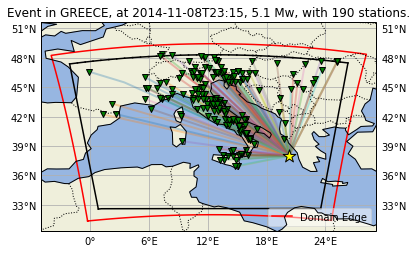

In [6]:
# Plot rays for one event
event = lasif.api.list_events(lasif_root, output=True)[0]
lasif.api.plot_event(
    lasif_root,
    event_name=event,
)

We can plot the raydensity of our project where the rays are coloured based on how many other rays each ray crosses on the way.


Launching 348 great circle calculations on 4 CPUs...


Progress: 100%|##################################################|Time: 0:00:08
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/matplotlib/pyplot.py:1337: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)


<Figure size 1440x864 with 0 Axes>

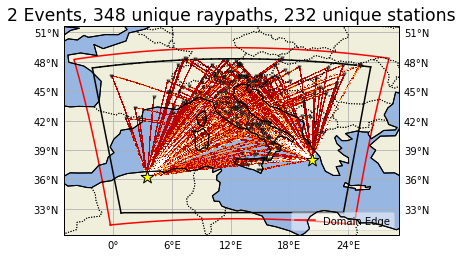

In [7]:
# Plot raydensity
lasif.api.plot_raydensity(
    lasif_root,
    plot_stations=True,
    save=False,
)

Alternatively we can simply plot all the rays in the project, without event considering the crossings. In this plot, rays from each event get the same color. The colors are currently completely random so this plot always has the potential to turn out terribly ugly but sometimes life is like that.

 13%|█▎        | 21/158 [00:00<00:01, 130.14it/s]

1 done from 2



100%|██████████| 158/158 [00:00<00:00, 447.70it/s]
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/matplotlib/pyplot.py:1337: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)


2 done from 2



<Figure size 1440x864 with 0 Axes>

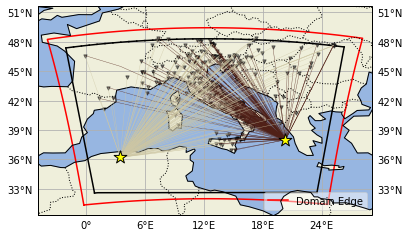

In [8]:
# Plot all rays:
lasif.api.plot_all_rays(
    lasif_root,
    plot_stations=True,
    save=False,
)

## Set up an iteration

Lasif organizes things through iterations. Each folder, except data and processed data, will have a subfolder with iterations where everything related to each iteration is stored. This creates the flexibility of using subsets of events per iteration. You can thus always define iterations on the full dataset or subsets of it and whenever you pass an iteration argument to one of the LASIF functions, it will know what applies to the relevant iteration.

Now, however we will use all of our events as we only have two events in our dataset.

In [9]:
first_iteration = "first"
lasif.api.set_up_iteration(lasif_root, iteration=first_iteration)

first already exists


All the plotting functions take iterations as arguments, so we can plot only the events defined in each iteration. In this case it doesn't make a difference but it would be done this way:

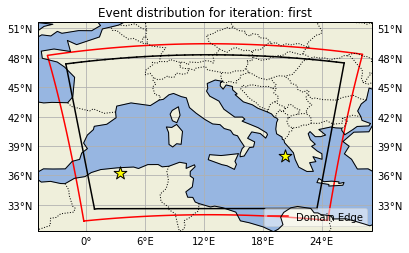

In [10]:
# Plot events for first iteration
lasif.api.plot_events(
    lasif_root,
    iteration=first_iteration
)

We can now see how the folder structure has changed by printing the folder tree again. We should both see some folders related to the new iteration and some data file since we found the events.

In [15]:
!tree

.
|-- Lasif_with_salvus.ipynb
|-- README.md
`-- lasif_project
    |-- ADJOINT_SOURCES
    |   `-- ITERATION_first
    |-- DATA
    |   |-- CORRELATIONS
    |   `-- EARTHQUAKES
    |       |-- GCMT_event_GREECE_Mag_5.1_2014-11-8-23.h5
    |       `-- GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23.h5
    |-- FUNCTIONS
    |   |-- __init__.py
    |   |-- preprocessing_function_asdf.py
    |   |-- process_data.py
    |   |-- process_synthetics.py
    |   |-- source_time_function.py
    |   `-- window_picking_function.py
    |-- GRADIENTS
    |   `-- ITERATION_first
    |-- ITERATIONS
    |   `-- ITERATION_first
    |       |-- central_info.toml
    |       `-- events_used.toml
    |-- MODELS
    |   |-- ITERATION_first
    |   |-- mesh.h5
    |   `-- mesh.xdmf
    |-- OUTPUT
    |   `-- LOGS
    |       `-- DOWNLOADS
    |           |-- 2020-03-18T16:42:59.343547Z___GCMT_event_GREECE_Mag_5.1_2014-11-8-23.log
    |           `-- 2020-03-18T16:55:10.273574Z___GCMT_event_NORTHERN_ALGERIA_Ma

## Run simulations

In order to see how good our starting model is we have to run wave propagation simulations.

Before running such simulations it is good to look into what is important to keep in mind when running simulations on a computational cluster.

* Find a timestep: You can initialize a short simulation on Salvus with the mesh you plan to use and take a look at the timestep that Salvus proposes. You should choose something very close to that timestep (preferrably shorter) which is a good number that you are comfortable with and you want your endtime to be a multiple of that number.

* Number of cores to use: It is a good rule of thumb to aim for about ~5000 elements per core and try not to go below ~1000 elements per core. This guarentees good scaling with cores, otherwise communication becomes dominant and scaling will plateau.

* Wall time: Keep in mind that wall time is only used to place you in the queue and it is not the time you will in the end be billed for. So make sure that the wall time you set is long enough to finish your simulation as the simulation will be killed if the wall time is passed. Also keep in mind that when using checkpointing, your adjoint simulation is about 3 times more expensive than your forward one.

* Cluster to use: This you have to set up yourself, using [SalvusFlow](https://mondaic.com/docs/installation/salvus_flow_configuration) where you can find some information on how to set things up correctly.

A part of the _LASIF_ library is a file called _salvus_utils.py_ where there are some functions which ease the usage of _Salvus_ with _LASIF_. We will demonstrate some of those now. But make sure that you already configured your cluster settings and update your __lasif_config.toml__ file accordingly.

In [16]:
# Update toml file
wall_time_in_s = 3600
# Our mesh has about 16.600 elements so we don't want more than 16 ranks.
# One node on Daint is 12 ranks so we'll use that although it is on the higher end for optimal scaling.
ranks = 12
site_name = "daint"
min_period = 35.0
# We recommend keeping the salvus absorbing boundaries a bit smaller than the domain ones
# as it is important to make sure we do not download receivers within the absorbing boundaries
absorbing_boundaries_in_km = 50.0
gradient_parameterization = "rho-vp-vs"
config_dict["salvus_settings"]["wall_time_in_s"] = wall_time_in_s
config_dict["salvus_settings"]["ranks"] = ranks
config_dict["salvus_settings"]["site_name"] = site_name
config_dict["salvus_settings"]["absorbing_boundaries_in_km"] = absorbing_boundaries_in_km
config_dict["salvus_settings"]["gradient_parameterization"] = gradient_parameterization
config_dict["simulation_settings"]["minimum_period_in_s"] = min_period


with open(config_file_path, "w") as fh:
    toml.dump(config_dict, fh)

In [12]:
# Create forward simulation objects

# We need the lasif communicator object to use the salvus utils:
lasif_comm = lasif.api.find_project_comm(lasif_root)
events = lasif.api.list_events(lasif_root, just_list=True, iteration=first_iteration, output=True)
simulations = []
for event in events:
    simulation = salvus_utils.create_salvus_forward_simulation(
        comm=lasif_comm,
        event=event,
        iteration=first_iteration,
        side_set="r1"
    )
    simulations.append(simulation)

100%|██████████| 190/190 [00:00<00:00, 22455.35it/s]

Writing receivers into a list of dictionaries
Wrote 190 receivers into a list of dictionaries


100%|██████████| 158/158 [00:00<00:00, 462456.41it/s]

Writing receivers into a list of dictionaries
Wrote 158 receivers into a list of dictionaries


In a Jupyter notebook the simulations can even be plotted which is nice to make sure everything looks correct.

In [13]:
# Plot simulations
simulations[1]

Now that we have created the Salvus simulation objects we can use _SalvusFlow_ to submit these simulations. The nice thing about _SalvusFlow_ is that it abstracts the cluster away from the workflow meaning that you do the exact same thing on your side whether you are working on your local computer or any other computer.

When we submit our simulations we have two options. We can submit them one by one and have separate job objects for each of them or we can submit them as a _JobArray_ and then they have a group JobArray object as well as their own ids. _LASIF_ keeps track of the job names and can figure it out for you how to query their statuses.

Whether a _JobArray_ or a _Job_ will be submitted depends on your input into the function. If you input a list of simulations, an array will be submitted but if you send one simulation, a single job will be submitted. Make sure that you submit a list of events which correspond to the list of your simulation objects. _LASIF_ can handle both the arrays and the single jobs.

In [19]:
# Run forward simulations
salvus_utils.submit_salvus_simulation(
    comm=lasif_comm,
    simulations=simulations,
    events=events,
    iteration=first_iteration,
    sim_type="forward"
)


Wrote job information into /Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/SALVUS_FILES/ITERATION_first/forward_jobs.toml


## Process data

While we wait for the simulation to be done, it is a good time to perform some tasks that we need to do anyway, like processing our raw data. Processing data can be done on an event level, an iteration level or full dataset level, it all depends on the input. The default is the full dataset, which we will do now.

Don't worry although it throws some errors. The script will process what data it can actually process. Unfortunately it seems to be unavoidable that when downloading data, a large chunk of the data we get are quite flawed and doesn't have all the relevant information we require. These data will be discarded.

In [20]:
# Process data

lasif.api.process_data(lasif_root)

Launching processing using multiprocessing on 4 cores ...
 -> Processing approximately task 0 of 190 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packag

 -> Processing approximately task 4 of 190 ...
 -> Processing approximately task 8 of 190 ...
 -> Processing approximately task 12 of 190 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in greater
  inn = np.where(sqrt_len > 0.0)
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 


Error during the processing of station 'CA.CBEU' and tag 'raw_recording' on CPU 0:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/solvi/Software/pyasdf/pyasdf/asdf_data_set.py", line 2753, in run
    output_stream = func(stream, inv)
  File "/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/FUNCTIONS/preprocessing_function_asdf.py", line 145, in process_function
    st.detrend("linear")
  File "<decorator-gen-159>", line 2, in detrend
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/core/util/decorator.py", line 235, in raise_if_masked
    return func(*args, **kwargs)
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-pa

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in greater
  inn = np.where(sqrt_len > 0.0)


 -> Processing approximately task 148 of 190 ...

Error during the processing of station 'RD.MFF' and tag 'raw_recording' on CPU 3:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/solvi/Software/pyasdf/pyasdf/asdf_data_set.py", line 2753, in run
    output_stream = func(stream, inv)
  File "/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/FUNCTIONS/preprocessing_function_asdf.py", line 145, in process_function
    st.detrend("linear")
  File "<decorator-gen-159>", line 2, in detrend
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/core/util/decorator.py", line 235, in raise_if_masked
    return func(*args, **kwargs)
  File "/Users/solvi/an

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


 -> Processing approximately task 184 of 190 ...
Finished processing in 21.03 seconds (0.11 sec/station).
Launching processing using multiprocessing on 4 cores ...
 -> Processing approximately task 0 of 158 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packag

 -> Processing approximately task 4 of 158 ...
 -> Processing approximately task 8 of 158 ...
 -> Processing approximately task 12 of 158 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in greater
  inn = np.where(sqrt_len > 0.0)
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 


Error during the processing of station 'CA.CBEU' and tag 'raw_recording' on CPU 1:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/solvi/Software/pyasdf/pyasdf/asdf_data_set.py", line 2753, in run
    output_stream = func(stream, inv)
  File "/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/FUNCTIONS/preprocessing_function_asdf.py", line 145, in process_function
    st.detrend("linear")
  File "<decorator-gen-159>", line 2, in detrend
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/core/util/decorator.py", line 235, in raise_if_masked
    return func(*args, **kwargs)
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-pa

 -> Processing approximately task 36 of 158 ...
 -> Processing approximately task 40 of 158 ...
 -> Processing approximately task 44 of 158 ...
 -> Processing approximately task 48 of 158 ...
 -> Processing approximately task 52 of 158 ...
 -> Processing approximately task 56 of 158 ...
 -> Processing approximately task 60 of 158 ...
 -> Processing approximately task 64 of 158 ...
 -> Processing approximately task 68 of 158 ...
 -> Processing approximately task 72 of 158 ...
 -> Processing approximately task 76 of 158 ...
 -> Processing approximately task 80 of 158 ...
 -> Processing approximately task 84 of 158 ...
 -> Processing approximately task 88 of 158 ...
 -> Processing approximately task 92 of 158 ...
 -> Processing approximately task 96 of 158 ...
 -> Processing approximately task 100 of 158 ...
 -> Processing approximately task 104 of 158 ...
 -> Processing approximately task 108 of 158 ...
 -> Processing approximately task 112 of 158 ...
 -> Processing approximately task 11

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:413: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in greater
  inn = np.where(sqrt_len > 0.0)


 -> Processing approximately task 124 of 158 ...

Error during the processing of station 'RD.MFF' and tag 'raw_recording' on CPU 2:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/solvi/Software/pyasdf/pyasdf/asdf_data_set.py", line 2753, in run
    output_stream = func(stream, inv)
  File "/Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/FUNCTIONS/preprocessing_function_asdf.py", line 145, in process_function
    st.detrend("linear")
  File "<decorator-gen-159>", line 2, in detrend
  File "/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/obspy/core/util/decorator.py", line 235, in raise_if_masked
    return func(*args, **kwargs)
  File "/Users/solvi/an

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


 -> Processing approximately task 158 of 158 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


 -> Processing approximately task 158 of 158 ...
Finished processing in 14.56 seconds (0.092 sec/station).


## Station weighting

In an inversion some regions with a high density of stations can become quite dominant in the resulting gradients as they emit more energy into the adjoint simulations compared to underrepresented regions. Partly this is a natural things which makes sense as more data means more information and should thus to some extent dominate an inversion but on the other hand this can also slow down convergence.

In _LASIF_ there is a function which computes weights for stations based on their geographical distribution. Using these weights reduces the effect of oversampled regions and we thus recommend using them as you only need to compute these weights once, it is very fast, and can potentially speed up your inversion.

In [16]:
# Compute station weights
station_weights = "stations"
lasif.api.compute_station_weights(
    lasif_root,
    weight_set=station_weights,
    iteration=first_iteration
)

Calculating station weights for event: GCMT_event_GREECE_Mag_5.1_2014-11-8-23


100%|██████████| 190/190 [00:00<00:00, 7777.61it/s]


Calculating station weights for event: GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23


100%|██████████| 158/158 [00:00<00:00, 7792.16it/s]


We can plot the station weights using the _plot_event_ function by passing a weight set argument to it. This is not the most beautiful plot currently. But I'll fix it, no worries.

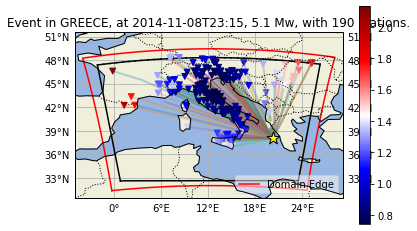

In [17]:
# Plot station weights:
event = lasif.api.list_events(
    lasif_root,
    output=True,
)[0]
lasif.api.plot_event(
    lasif_root,
    event_name=event,
    weight_set_name=station_weights,
)

## Retrieve simulation outputs

_SalvusFlow_ defines it's own location where it runs its simulations and after they are done, we need to download the relevant output into the correct locations for _LASIF_ to recognize them. The Salvus utils can do this for you based on the job names it saved before.

When you ask _LASIF_ to retrieve outputs from a simulation, it will check whether the simulation terminated successfully, terminated with an error or whatever else might be going. It can obviously only download the output if the simulation terminated successfully, otherwise it will report the status of the simulation.

In [23]:
# Retrieve synthetic seismograms
# lasif_comm = lasif.api.find_project_comm(lasif_root)
# events = lasif.api.list_events(lasif_root, just_list=True, iteration=first_iteration, output=True)
lasif.salvus_utils.retrieve_salvus_simulations(
    comm=lasif_comm,
    events=events,
    iteration=first_iteration,
    sim_type="forward"
)

## Graphical user interface

_LASIF_ is equipped with a Graphical User Interface (GUI) which can be used to plot waveforms from specific stations, explore windows and compare waveforms between iterations. The GUI can either be opened from the command line by typing `lasif gui` into a terminal window or via the API by running the cell below. I would not really recommend it though as it tends to kill the kernel. Rather just open it from the terminal.

In [ ]:
# Open GUI
lasif.api.open_gui(lasif_root)

(2, 140)


TypeError: plot_events() missing 2 required positional arguments: 'projection' and 'domain'

TypeError: plot_events() missing 2 required positional arguments: 'projection' and 'domain'

## Window selection

When comparing waveforms it is important that they are sufficiently similar in order to do a meaningful measurement of the difference between them. The main things to keep in mind are:

* Phase jumps: When two waves are compared they are often compared in terms of phase and then the wiggle closest to the reference wiggle is considered to be the relevant wiggle of comparison. But if the phase shift between the wiggles is too large, the correct wiggle might not be the closest one anymore resulting in a completely wrong measurement.

* Noise: If a trace has a high noise level then it is hard to separate the signal from the noise. A signal to noise ratio test is thus of great importance and we do not want to use traces with a low ratio. Quality of signal over quantity in that sense.

The window selection algorithm in _LASIF_ tries to account for these two things and selects parts of the waveforms which can be compared in a meaningful way. As your model gets better, larger parts of the waveforms become measurable and it can thus be of great benefit to be able to repick windows as often as possible. How feasible it is to repick windows regularly depends on your inversion algorithm.

It is impossible to be completely correct with such window selection algorithms and the same can be said about human picking. With the vast data volumes we have today it is a huge waste of time to manually pick all windows in your waveforms and thus the best thing we can do is to try to improve our window picking algorithms.

What the window selection does to your inversion is essentially to linearize it. Through possible phase jumps and elevated noise levels many local minima can appear in your misfit function and we want to get past this. That is the reason we pick windows.

_LASIF_ can pick windows in parallel if you call it from the command line, but it can also pick windows via the API, just not parallelly currently. Since we have a small dataset here we will use the API.

In [14]:
# Select windows
window_set="A"
lasif.api.select_windows(lasif_root, iteration=first_iteration, window_set=window_set)

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


Selecting windows for event: GCMT_event_GREECE_Mag_5.1_2014-11-8-23
 -> Processing approximately task 1 of 190 ...
 -> Processing approximately task 2 of 190 ...
 -> Processing approximately task 3 of 190 ...
 -> Processing approximately task 4 of 190 ...
 -> Processing approximately task 5 of 190 ...
 -> Processing approximately task 6 of 190 ...
 -> Processing approximately task 7 of 190 ...
 -> Processing approximately task 8 of 190 ...
 -> Processing approximately task 9 of 190 ...
 -> Processing approximately task 10 of 190 ...
 -> Processing approximately task 11 of 190 ...
 -> Processing approximately task 12 of 190 ...
 -> Processing approximately task 13 of 190 ...
 -> Processing approximately task 14 of 190 ...
 -> Processing approximately task 15 of 190 ...
 -> Processing approximately task 16 of 190 ...
 -> Processing approximately task 17 of 190 ...
 -> Processing approximately task 18 of 190 ...
 -> Processing approximately task 19 of 190 ...
 -> Processing approximately 

 -> Processing approximately task 154 of 190 ...
 -> Processing approximately task 155 of 190 ...

Error during the processing of station 'CA.CBEU' on rank 0:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/Software/LASIF_2.0/lasif/api.py", line 734, in select_windows
    comm.windows.select_windows(event, iteration, window_set)
  File "/Users/solvi/Software/LASIF_2.0/lasif/components/windows.py", line 299, in select_windows
    ds, ds_synth, process
  File "/Users/solvi/Software/LASIF_2.0/lasif/utils.py", line 403, in process_two_files_without_parallel_output
    getattr(other_ds.waveforms, station),
  File "/Users/solvi/Software/LASIF_2.0/lasif/components/windows.py", line 225, in process
    % (observed_station._station_name, len(obs_tag))

AssertionError: Station: CA.CBEU - Requires 1 observed waveform tag. Has 0.

 -> Processing approximately task 156 of 190 ...
 -> Processing approximately task 157 of 190 ...
 -> Processing approximately task 158 of 190 

/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


Selecting windows for event: GCMT_event_NORTHERN_ALGERIA_Mag_5.3_2016-5-28-23
 -> Processing approximately task 1 of 158 ...
 -> Processing approximately task 2 of 158 ...
 -> Processing approximately task 3 of 158 ...
 -> Processing approximately task 4 of 158 ...
 -> Processing approximately task 5 of 158 ...
 -> Processing approximately task 6 of 158 ...
 -> Processing approximately task 7 of 158 ...
 -> Processing approximately task 8 of 158 ...
 -> Processing approximately task 9 of 158 ...
 -> Processing approximately task 10 of 158 ...

Error during the processing of station 'CA.VILA' on rank 0:
Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/Software/LASIF_2.0/lasif/api.py", line 734, in select_windows
    comm.windows.select_windows(event, iteration, window_set)
  File "/Users/solvi/Software/LASIF_2.0/lasif/components/windows.py", line 299, in select_windows
    ds, ds_synth, process
  File "/Users/solvi/Software/LASIF_2.0/lasif/utils.py", line 403, i

 -> Processing approximately task 130 of 158 ...
 -> Processing approximately task 131 of 158 ...
 -> Processing approximately task 132 of 158 ...
 -> Processing approximately task 133 of 158 ...
 -> Processing approximately task 134 of 158 ...
 -> Processing approximately task 135 of 158 ...
 -> Processing approximately task 136 of 158 ...
 -> Processing approximately task 137 of 158 ...
 -> Processing approximately task 138 of 158 ...
 -> Processing approximately task 139 of 158 ...
 -> Processing approximately task 140 of 158 ...
 -> Processing approximately task 141 of 158 ...
 -> Processing approximately task 142 of 158 ...
 -> Processing approximately task 143 of 158 ...
 -> Processing approximately task 144 of 158 ...
 -> Processing approximately task 145 of 158 ...
 -> Processing approximately task 146 of 158 ...
 -> Processing approximately task 147 of 158 ...
 -> Processing approximately task 148 of 158 ...
 -> Processing approximately task 149 of 158 ...
 -> Processing appro

## Compute adjoint sources

As we have estimated where we can make meaningful measurements between synthetics and data, it is time to do these measurements. In _LASIF_ there are a few different misfit measurements which can be used. Most importantly the classic L2 waveform misfit:

$$ \chi = \frac{1}{2} \int_{t=0}^{t=\tau}(d_{syn}(t) - d_{obs}(t))^2 dt $$

That one is probably the most straightforward and always works best in any synthetic test case where our physics are perfectly modelled. The L2 misfits takes in amplitude information which we do not understand as well as we do phase information and it can thus be a bit dangerous in practice. There are some remedies to that like using normalized L2, regularized L2 or starting with a different misfit function and do a few L2 iterations at the end when you are sort of sure you are in the vicinity of a good minimum. L2 is usually far from convex and is thus a bit dangerous in real data cases.

Another one is the cross correlation time shift where we keep one trace fixed and time shift the other one within a certain time range:

$$ \chi = argmax((f(t) * g(t-\tau))$$

The $\tau$ which produces the highest correlation between the two signals is picked as the time shift between the two. Problem with this misfit function is that as opposed to the L2 which has information on every time step of the waveform, the cross correlation simply makes one measurement for each window in the seismogram.

Then there is the misfit which we will use in this tutorial, the time-frequency phase misfit which we will not describe here but refer to [Fichtner et al. 2008](https://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.2008.03923.x). Maybe at some point more info on that will be added here.

The same parallel relation applies to the adjoint source calculations as did with the window selection.

In [18]:
# Compute adjoint sources
lasif.api.calculate_adjoint_sources(
    lasif_root,
    iteration=first_iteration,
    window_set=window_set,
    weight_set=station_weights
)


Starting adjoint source calculation for event 1 of 2...

 -> Processing approximately task 1 of 190 ...
 -> Processing approximately task 2 of 190 ...


/Users/solvi/anaconda3/envs/test_notebook/lib/python3.7/site-packages/numpy/core/numerictypes.py:422: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  FutureWarning, stacklevel=2


 -> Processing approximately task 3 of 190 ...
 -> Processing approximately task 4 of 190 ...
 -> Processing approximately task 5 of 190 ...
 -> Processing approximately task 6 of 190 ...
 -> Processing approximately task 7 of 190 ...
 -> Processing approximately task 8 of 190 ...
 -> Processing approximately task 9 of 190 ...
 -> Processing approximately task 10 of 190 ...
 -> Processing approximately task 11 of 190 ...
 -> Processing approximately task 12 of 190 ...
 -> Processing approximately task 13 of 190 ...
 -> Processing approximately task 14 of 190 ...
 -> Processing approximately task 15 of 190 ...
 -> Processing approximately task 16 of 190 ...
 -> Processing approximately task 17 of 190 ...
 -> Processing approximately task 18 of 190 ...
 -> Processing approximately task 19 of 190 ...
 -> Processing approximately task 20 of 190 ...
 -> Processing approximately task 21 of 190 ...
 -> Processing approximately task 22 of 190 ...
 -> Processing approximately task 23 of 190 ...

Traceback (At max 3 levels - most recent call last):
  File "/Users/solvi/Software/LASIF_2.0/lasif/api.py", line 709, in calculate_adjoint_sources
    event, iteration, window_set
  File "/Users/solvi/Software/LASIF_2.0/lasif/components/adjoint_sources.py", line 275, in calculate_adjoint_sources
    ds, ds_synth, process
  File "/Users/solvi/Software/LASIF_2.0/lasif/utils.py", line 403, in process_two_files_without_parallel_output
    getattr(other_ds.waveforms, station),
  File "/Users/solvi/Software/LASIF_2.0/lasif/components/adjoint_sources.py", line 174, in process
    % (observed_station._station_name, len(obs_tag))

AssertionError: Station: CA.CBEU - Requires 1 observed waveform tag. Has 0.

 -> Processing approximately task 156 of 190 ...
 -> Processing approximately task 157 of 190 ...
 -> Processing approximately task 158 of 190 ...
 -> Processing approximately task 159 of 190 ...
 -> Processing approximately task 160 of 190 ...
 -> Processing approximately task 161 of 190 ...

 -> Processing approximately task 67 of 158 ...
 -> Processing approximately task 68 of 158 ...
 -> Processing approximately task 69 of 158 ...
 -> Processing approximately task 70 of 158 ...
 -> Processing approximately task 71 of 158 ...
 -> Processing approximately task 72 of 158 ...
 -> Processing approximately task 73 of 158 ...
 -> Processing approximately task 74 of 158 ...
 -> Processing approximately task 75 of 158 ...
 -> Processing approximately task 76 of 158 ...
 -> Processing approximately task 77 of 158 ...
 -> Processing approximately task 78 of 158 ...
 -> Processing approximately task 79 of 158 ...
 -> Processing approximately task 80 of 158 ...
 -> Processing approximately task 81 of 158 ...
 -> Processing approximately task 82 of 158 ...
 -> Processing approximately task 83 of 158 ...
 -> Processing approximately task 84 of 158 ...
 -> Processing approximately task 85 of 158 ...
 -> Processing approximately task 86 of 158 ...
 -> Processing approximately task 87 of 

## Create adjoint simulation

In the same way as we created a Salvus simulation object before, we have to do exactly the same thing for the adjoint simulations.

We do this in basically the exact same way as the forward simulation, except now we change the _sim_type_ attribute to "adjoint". Simple as that.

In [19]:
# Create adjoint simulations
lasif_comm = lasif.api.find_project_comm(lasif_root)
events = lasif.api.list_events(lasif_root, just_list=True, iteration=first_iteration, output=True)
simulations = []
for event in events:
    simulation = salvus_utils.create_salvus_adjoint_simulation(
        comm=lasif_comm,
        event=event,
        iteration=first_iteration,
    )
    simulations.append(simulation)

100%|██████████| 190/190 [00:00<00:00, 683462.92it/s]

Writing receivers into a list of dictionaries
Wrote 190 receivers into a list of dictionaries



100%|██████████| 158/158 [00:00<00:00, 592225.23it/s]

Writing receivers into a list of dictionaries
Wrote 158 receivers into a list of dictionaries


## Submit adjoint simulation

This is done in the exact same way as the forward simulation, the only need is to change the _sim_type_ attribute to "adjoint". It's as simple as that. Keep in mind though that the adjoint simulation is about 2-3 times more expensive than the forward one meaning that you might need an increased wall time.

In [20]:
# Submit adjoint simulation
lasif.salvus_utils.submit_salvus_simulation(
    comm=lasif_comm,
    simulations=simulations,
    events=events,
    iteration=first_iteration,
    sim_type="adjoint",
)


Wrote job information into /Users/solvi/PhD/workspace/LASIF/LASIF_tutorials/lasif_project/SALVUS_FILES/ITERATION_first/adjoint_jobs.toml


## Retrieve gradients

Again this works just the same as the retrieving of the seismograms. It checks the job status and acts accordingly. It can sometimes take a bit of time to figure out the status of each job. In order to reduce the time, it is good to regularly empty or clean your _SalvusFlow_ database. Let's try to retrieve our jobs.

In [22]:
# Retrieve gradients
lasif_comm = lasif.api.find_project_comm(lasif_root)
events = lasif.api.list_events(lasif_root, just_list=True, iteration=first_iteration, output=True)
lasif.salvus_utils.retrieve_salvus_simulations(
    comm=lasif_comm,
    events=events,
    iteration=first_iteration,
    sim_type="adjoint",
)

As you open the gradient files in [Paraview](https://www.paraview.org/) you'll notice that the sensitivities are mostly focussed around the sources and receivers. For that reason, sometimes small regions around the sources and the receivers are cut away from the gradients and the gradient then smoothed. This effect is strongest around the source, so I would especially recommend cutting that region out.

# End of tutorial

Congratulations, you've made it to the end of this tutorial.

What has been described for you is what _LASIF_ can do for you in a full-waveform inversion using _Salvus_. There are obviously things that _LASIF_ does not do for you. Namely

* Regularization - You can either implement this yourself or use what is implemented in Salvus
* Optimization - As FWI is a non-linear optimization problem, you need to figure out what to do between iterations. This is, like the regularization, something you can either implement your self, or use what is implemented in Salvus.

There are currently no plans to include this in _LASIF_. If you are interested in running your inversion automatically, you might want to take a look at [_Inversionson_](http://www.github.com/solvithrastar/inversionson) which uses _LASIF_ and _SALVUS_ and fully automates the inversion workflow.

## Current future LASIF plans

As time becomes available we have some things that we would like to improve in _LASIF_. One of those things is to add some new plotting functionalities which make it easier to follow the process of the inversion. This will hopefully be added in the very near future.

There have also been some discussion of making _LASIF_ support other solvers in a way it supports _Salvus_. As _LASIF_ is independent of _Salvus_, it can be used with other solvers but further support might be helpfull.

### Suggestions

If you have any ideas of what might be a nice addition to _LASIF_ feel free to either send us a suggestion, via email (soelvi.thrastarson@erdw.ethz.ch) or on [Github](www.github.com/dirkphilip/LASIF_2.0), or to code it up yourself and submit a pull request.